In [1]:
# Standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import argrelmin

# Custom modules
from jpm_logger import JpmLogger

__author__ = 'James Paul Mason'
__contact__ = 'jmason86@gmail.com'


def determine_dimming_depth(light_curve_df, 
                            earliest_allowed_time=None, latest_allowed_time=None, smooth_points=0, 
                            plot_path_filename=None, verbose=False):
    """Find the depth of dimming in a light curve, if any.
    Assumes light curve is normalized such that pre-flare = 0%.

    Inputs:
        light_curve_df [pd DataFrame]:    A pandas DataFrame with a DatetimeIndex and a column for irradiance.
        
    Optional Inputs:
        earliest_allowed_time [metatime]: The function won't return a depth determined any earlier than this.
                                          Default is None, meaning the beginning of the light_curve_df.
        latest_allowed_time [metatime]:   The function won't return a depth determined any later than this.
                                          Default is None, meaning the end of the light_curve_df.
        smooth_points [integer]:          Used to apply a rolling mean with the number of points (indices) specified.
                                          Default is 0, meaning no smoothing will be performed.
        plot_path_filename [str]:         Set to a path and filename in order to save the summary plot to disk.
                                          Default is None, meaning the plot will not be saved to disk.
        verbose [bool]:                   Set to log the processing messages to disk and console. Default is False.

    Outputs:
        depth_percent [float]: The depth of dimming in percent terms. 
                                                 
    Optional Outputs:
        None

    Example:
        depth_percent = determine_dimming_depth(light_curve_df,
                                                      plot_path_filename='./bla.png',
                                                      verbose=True)
    """
    return 1

In [2]:
# prototype only: set up example inputs
%matplotlib inline
plt.style.use('jpm-transparent-light')
earliest_allowed_time = pd.Timestamp('2012-04-15 17:52:20.0')
latest_allowed_time = None
smooth_points = 0
plot_path_filename = './bla.png'
verbose = True

light_curve_df = pd.read_hdf('/Users/jmason86/Dropbox/Research/Postdoc_NASA/Analysis/Coronal Dimming Analysis/Example Fit Dimming Light Curve.hdf',
                             'light_curve_df')
light_curve_df['irradiance'] = light_curve_df['irradiance'] - 1  # Just need something under 0%
light_curve_df.head()

,irradiance,uncertainty
2012-04-15 17:43:20,-0.851300,0.160099
2012-04-15 17:44:19,-0.700667,0.160099
2012-04-15 17:45:18,-0.559752,0.160099
2012-04-15 17:46:17,-0.428509,0.160099
2012-04-15 17:47:16,-0.306866,0.160099


In [3]:
# Prepare the logger for verbose
if verbose:
    # TODO: Update the path
    logger = JpmLogger(filename='determine_dimming_depth_log', path='/Users/jmason86/Desktop/')
    logger.info("Running on event with light curve start time of {0}.".format(light_curve_df.index[0]))

2018-01-02 15:33:05,666 [INFO ] [<module>] Running on event with light curve start time of 2012-04-15 17:43:20.


In [4]:
# If no earliest_allowed_time set, then set it to beginning of light_curve_df
if not earliest_allowed_time:
    earliest_allowed_time = light_curve_df.index[0]
    logger.info("No earliest allowed time provided. Setting to beginning of light curve: {0}".format(earliest_allowed_time))
    
# If no latest_allowed_time set, then set it to end of light_curve_df
if not latest_allowed_time:
    latest_allowed_time = light_curve_df.index[-1]
    logger.info("No latest allowed time provided. Setting to end of light curve: {0}".format(latest_allowed_time))

2018-01-02 15:33:05,675 [INFO ] [<module>] No latest allowed time provided. Setting to end of light curve: 2012-04-15 21:38:21


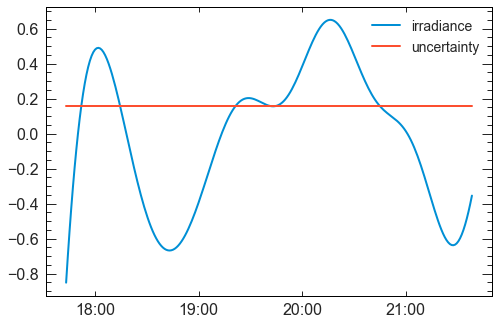

In [5]:
# Optionally smooth the light curve with a rolling mean 
if smooth_points:
    light_curve_df['irradiance'] = light_curve_df.rolling(smooth_points, center=True).mean()
    if verbose:
        logger.info('Applied {0} point smooth.'.format(smooth_points))
        
first_non_nan = light_curve_df['irradiance'].first_valid_index()
nan_indices = np.isnan(light_curve_df['irradiance'])
light_curve_df['irradiance'][nan_indices] = light_curve_df['irradiance'][first_non_nan]

# prototype only: just look at the data real quick
light_curve_df.plot();

In [6]:
# Find the local minima
minima_indices = argrelmin(light_curve_df['irradiance'].values)[0]
minima_times = light_curve_df.index[minima_indices]
minima_irradiances = light_curve_df['irradiance'].values[minima_indices]
if verbose:
    if minima_indices.size > 0:
        logger.info('Found {0} local minima.'.format(minima_indices.size))
    else:
        logger.warning('No local minima found.')

2018-01-02 15:33:05,965 [INFO ] [<module>] Found 3 local minima.


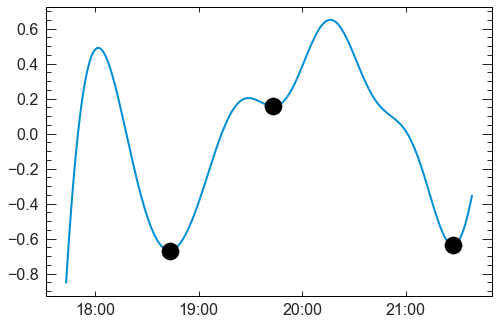

In [7]:
# prototype only: sanity check plot
light_curve_df['irradiance'].plot()
plt.scatter(minima_times, minima_irradiances, 
            c='black', s=300, zorder=3);

In [8]:
# Apply conditions to obtain what we'll call the dimming depth
less_than_zero_indices = minima_indices[minima_irradiances < 0]  # Assumes 0 is the baseline
if less_than_zero_indices.size > 0:
    depth_index = less_than_zero_indices[0] # First one
    depth_time = light_curve_df.index[depth_index]
    depth = np.abs(light_curve_df['irradiance'].values[depth_index])
    if verbose:
        logger.info('Depth determiend to be {0:.2f} at {1}'.format(depth, depth_time))
else:
    depth = None
    if verbose and minima_indices.size > 0:
        logger.warning('None of the minima are below 0.')

2018-01-02 15:33:06,207 [INFO ] [<module>] Depth determiend to be 0.67 at 2012-04-15 18:43:19


2018-01-02 16:24:49,673 [INFO ] [<module>] Summary plot saved to ./bla.png


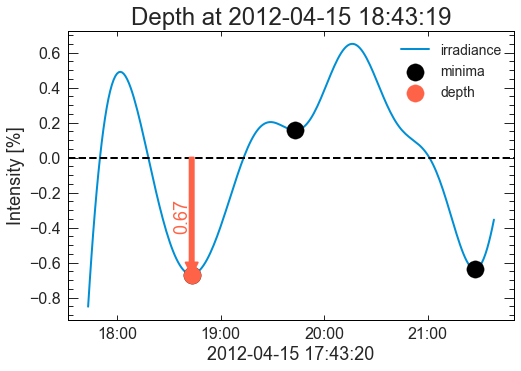

In [13]:
# Produce a summary plot
if plot_path_filename:
    plt.style.use('jpm-transparent-light')
    from matplotlib import dates
    
    ax = light_curve_df['irradiance'].plot()
    plt.scatter(minima_times, minima_irradiances, 
                c='black', s=300, zorder=3, label='minima')
    if depth:
        plt.scatter(depth_time, -depth, 
                    c='tomato', s=300, zorder=3, label='depth')
        plt.title('Depth at ' + str(depth_time))
    else:
        plt.title('No Depth Found')
    plt.axhline(linestyle='dashed', color='black')
    start_date = light_curve_df.index.values[0]
    start_date_string = pd.to_datetime(str(start_date))
    plt.xlabel(start_date_string.strftime('%Y-%m-%d %H:%M:%S'))
    plt.ylabel('Irradiance [%]')
    fmtr = dates.DateFormatter("%H:%M:%S")
    ax.xaxis.set_major_formatter(fmtr)
    ax.xaxis.set_major_locator(dates.HourLocator())
    ax.xaxis.grid(b=True, which='minor')
    ax.legend(loc='best')
    
    if depth:
        plt.annotate('', xy=(depth_time, -depth), xycoords='data',
                     xytext=(depth_time, 0), textcoords='data',
                     arrowprops=dict(facecolor='tomato', edgecolor='tomato', linewidth=2))
        mid_depth = -depth / 2.0
        plt.annotate('{0:.2f}'.format(depth), xy=(depth_time, mid_depth), xycoords='data', ha='right', va='center', 
                     rotation=90, size=18, color='tomato')
    
    plt.savefig(plot_path_filename)
    if verbose:
        logger.info("Summary plot saved to %s" % plot_path_filename)

In [10]:
# Return the depth
return depth

SyntaxError: 'return' outside function (<ipython-input-10-b51cc6ad46b6>, line 2)